In [7]:
import nest
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
def spikes_to_csv(espikes, ispikes, N_total, g, eta):
    '''
    Extracts spike data from NEST spike recorders and saves to a CSV file.
    '''
    print("Extracting data...")
    # Get events from the recorder
    # nest.GetStatus returns a list of dictionaries. 
    ex_events = nest.GetStatus(espikes, "events")[0]
    in_events = nest.GetStatus(ispikes, "events")[0]

    # Convert to DataFrames (easier to handle)
    df_ex = pd.DataFrame({
        "sender": ex_events["senders"],
        "time_ms": ex_events["times"],
        "type": "excitatory"
    })

    df_in = pd.DataFrame({
        "sender": in_events["senders"],
        "time_ms": in_events["times"],
        "type": "inhibitory"
    })

    # Combine and Save to ONE file
    all_spikes = pd.concat([df_ex, df_in])

    # Sort by time
    all_spikes = all_spikes.sort_values(by="time_ms")

    # Save to CSV
    filename = f"data/brunel_{N_total}_{g}_{eta}.csv"
    all_spikes.to_csv(filename, index=False)

    print(f"Saved {len(all_spikes)} spikes to {filename}")

In [10]:
def analyze_population_dynamics(spike_times, N_neurons, sim_time, dt_bin=2.0):
    '''
    Calculates the instantaneous population rate A(t) and its distribution.
    
    Parameters:
    - spike_times: List or array of spike timestamps (ms)
    - N_neurons: Number of neurons in the population being analyzed
    - sim_time: Total simulation duration (ms)
    - dt_bin: Width of the time bin for calculation (ms). 
              2.0 ms is usually good for capturing fast oscillations.
    '''
    
    # Define time bins
    bins = np.arange(0, sim_time + dt_bin, dt_bin)
    
    # Bin the spikes (Count spikes per bin)
    spike_counts, _ = np.histogram(spike_times, bins=bins)
    
    # Convert Count -> Rate (Hz)
    # Rate = Count / (Number_of_Neurons * Bin_Width_in_Seconds)
    bin_width_sec = dt_bin / 1000.0
    A_t = spike_counts / (N_neurons * bin_width_sec)
    
    # Remove transient (Optional but recommended)
    # The first ~100ms often contains startup artifacts.
    warmup_bins = int(100 / dt_bin) 
    A_t_steady = A_t[warmup_bins:] 
    
    return bins[:-1], A_t, A_t_steady

In [19]:
def run_brunel_network(N_total=12500, epsilon=0.1, J_ex=0.1, g=5.0, eta=2.0, sim_time=1100.0):
    '''
    Simulates a Brunel network of spiking neurons using NEST.
    Parameters:
    - N_total: Total number of neurons in the network.
    - epsilon: Connection probability.
    - J_ex: Excitatory synaptic weight amplitude (mV).
    - g: Relative inhibitory strength (J_in = -g * J_ex).
    - eta: External rate relative to threshold.
    - sim_time: Duration of the simulation in milliseconds.
    '''
    # NEST Initialization
    # -------------------
    nest.ResetKernel()
    nest.total_num_virtual_procs = 5
    nest.set_verbosity("M_WARNING")

    # Parameter Definition
    # -----------------------
    # Network parameters
    NE = int(0.8 * N_total)    # Number of Excitatory neurons
    NI = int(0.2 * N_total)    # Number of Inhibitory neurons
    
    # Connection parameters
    CE = int(epsilon * NE)     # Indegree from Excitatory
    CI = int(epsilon * NI)     # Indegree from Inhibitory

    # Neuron parameters (from Gerstner et al. 2014)
    tauMem = 20.0  # time constant of membrane potential in ms
    CMem = 1.0  # capacitance of membrane in in pF
    theta = 20.0  # membrane threshold potential in mV
    neuron_params = {
        "C_m": CMem,
        "tau_m": tauMem,
        "t_ref": 2.0,
        "E_L": 0.0,
        "V_reset": 10.0,
        "V_th": theta,
    }
        
    # Synaptic weights
    J_in = -g * J_ex           # Inhibitory weight amplitude
    delay = 1.5                # Synaptic delay (ms)

    # External drive parameters
    nu_th = (theta / (J_ex * CE * tauMem)) * 1000.0   # Threshold rate (Hz) - approximated for parameters
    nu_ext = eta * nu_th       # External Poisson rate (Hz)
    p_rate = nu_ext * CE # Poisson generator rate (spikes/s)

    # Simulation parameters
    dt = 0.1                   # Simulation resolution (ms)

    nest.resolution = dt
    nest.print_time = True
    nest.overwrite_files = True

    print(f"Building network with {N_total} neurons...")

    # Create Nodes
    # ---------------
    # Create neurons (iaf_psc_delta is standard for Brunel 2000)
    nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
    nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
    
    # Create external noise (Poisson generator)
    noise = nest.Create("poisson_generator", N_total, params={"rate": p_rate})
    noise.rate = nu_ext * CE  # Rate adjusted for indegree

    # Create spike recorder for excitatory and inhibitory neurons
    espikes = nest.Create("spike_recorder")
    espikes.set(label="brunel-py-ex")
    ispikes = nest.Create("spike_recorder")
    ispikes.set(label="brunel-py-in")

    # Connect Network
    # ------------------
    # Configure synapse specifications
    syn_ex = {"weight": J_ex, "delay": delay}
    syn_in = {"weight": J_in, "delay": delay}
    
    # Configure connection rule (Fixed Indegree)
    conn_params_ex = {"rule": "fixed_indegree", "indegree": CE}
    conn_params_in = {"rule": "fixed_indegree", "indegree": CI}

    print("Connecting devices...")

    nest.CopyModel("static_synapse", "excitatory", syn_ex)
    nest.CopyModel("static_synapse", "inhibitory", syn_in)
    
    # Connect External Noise -> All Neurons
    nest.Connect(noise, nodes_ex + nodes_in, "one_to_one", syn_spec="excitatory")
    # Connect Excitatory Population -> All Neurons
    nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, syn_ex)
    # Connect Inhibitory Population -> All Neurons
    nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, syn_in)

    # Connect Neurons -> Spike Recorder
    # (Recording only first 50 E and 50 I neurons to save memory)
    nest.Connect(nodes_ex, espikes, syn_spec="static_synapse")
    nest.Connect(nodes_in, ispikes, syn_spec="static_synapse")

    # Run Simulation
    # -----------------
    print(f"Simulating for {sim_time} ms...")
    start_time = time.time()
    nest.Simulate(sim_time)
    end_time = time.time()
    
    print(f"Simulation finished in {end_time - start_time:.2f} s")

    events = nest.GetStatus(espikes, "events")[0]
    spikes_t = events["times"]

    # Calculate Dynamics
    # We analyze only the Excitatory population (standard practice for Brunel)
    time_axis, A_t, A_t_steady = analyze_population_dynamics(spikes_t, NE, sim_time, dt_bin=2.0)

    # Calculate Statistics
    mean_rate = np.mean(A_t_steady)
    std_rate = np.std(A_t_steady)

    print(f"Mean Population Rate: {mean_rate:.2f} Hz")
    print(f"Std Dev of Rate: {std_rate:.2f} Hz")

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot A(t) - The Time Series
    ax1.plot(time_axis, A_t, color='k', lw=1)
    ax1.set_title("Instantaneous Population Rate A(t)")
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Frequency (Hz)")
    ax1.axhline(mean_rate, color='red', linestyle='--', label='Mean')
    ax1.legend()

    # Plot P(A) - The Distribution
    ax2.hist(A_t_steady, bins=30, color='gray', edgecolor='black', density=True)
    ax2.set_title("Distribution of Population Rates")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Probability Density")
    ax2.axvline(mean_rate, color='red', linestyle='--', label=f'Mean: {mean_rate:.1f} Hz')
    ax2.legend()

    plt.tight_layout()
    plt.show()

Building network with 12500 neurons...
Connecting devices...
Simulating for 1100.0 ms...

[   0% ] Model time: 0.0 ms, Real-time factor: 0.0000Simulation finished in 10.56 s
[ 100% ] Model time: 1100.0 ms, Real-time factor: 9.3237
Mean Population Rate: 37.77 Hz
Std Dev of Rate: 18.86 Hz


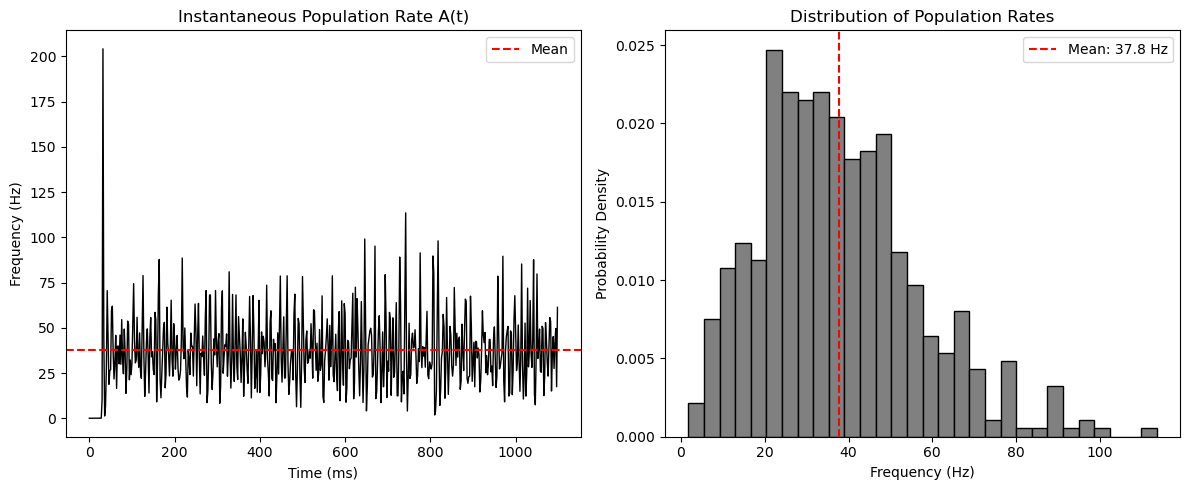

In [20]:
run_brunel_network()